In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from utils import params

In [27]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Losses/loss_burnin_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_burnin = CPU_Unpickler(pickle_file).load()

file_path = 'Losses/loss_main_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_main = CPU_Unpickler(pickle_file).load()

file_path = 'Losses/loss_refine_all.pkl'
with open(file_path, 'rb') as pickle_file:
    loss_refine = CPU_Unpickler(pickle_file).load()

In [28]:
def moving_average(arr, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(arr, window, mode='valid')
window_size = 50

# Burin Losses Read

In [29]:
# burnin losses
occu_burnin = []
flow_burnin = []
speed_burnin = []
k_t_burnin = []
burnin_losses = []

In [30]:
num_epochs_burnin = params['burn_in_epoch']
for epoch_burnin in range(num_epochs_burnin):
    occu_burnin.append(loss_burnin[epoch_burnin]['occupancy'].item())
    flow_burnin.append(loss_burnin[epoch_burnin]['flow'].item())
    speed_burnin.append(loss_burnin[epoch_burnin]['speed'].item())
    k_t_burnin.append(loss_burnin[epoch_burnin]['k_t'].item())
    burnin_losses.append(params['occupancy_weight']*(loss_burnin[epoch_burnin]['occupancy'].item())\
                  +params['flow_weight']*(loss_burnin[epoch_burnin]['flow'].item())\
                  +params['speed_weight']*(loss_burnin[epoch_burnin]['speed'].item())\
                  +params['k_t_weight']*(loss_burnin[epoch_burnin]['k_t'].item()))

# Main Losses Read

In [31]:
# main losses
occu_main = []
flow_main = []
speed_main = []
k_t_main = []
main_losses = []

In [32]:
num_epochs_main = params['num_epochs']
for epoch_main in range(num_epochs_main):
    occu_main.append(loss_main[epoch_main]['occupancy'].item())
    flow_main.append(loss_main[epoch_main]['flow'].item())
    speed_main.append(loss_main[epoch_main]['speed'].item())
    k_t_main.append(loss_main[epoch_main]['k_t'].item())
    main_losses.append(params['occupancy_weight']*(loss_main[epoch_main]['occupancy'].item())\
                  +params['flow_weight']*(loss_main[epoch_main]['flow'].item())\
                  +params['speed_weight']*(loss_main[epoch_main]['speed'].item())\
                  +params['k_t_weight']*(loss_main[epoch_main]['k_t'].item())\
                  +params['sparsity_weight'] * loss_main[epoch_main]['sparsity'])

# Refinement Losses Read

In [33]:
# refine losses
occu_refine = []
flow_refine = []
speed_refine = []
k_t_refine = []
refine_losses = []

In [34]:
num_epochs_refine = params['refinement_epochs']
for epoch_refine in range(num_epochs_refine):
    occu_refine.append(loss_refine[epoch_refine]['occupancy'].item())
    flow_refine.append(loss_refine[epoch_refine]['flow'].item())
    speed_refine.append(loss_refine[epoch_refine]['speed'].item())
    k_t_refine.append(loss_refine[epoch_refine]['k_t'].item())
    refine_losses.append(params['occupancy_weight']*(loss_refine[epoch_refine]['occupancy'].item())\
                  +params['flow_weight']*(loss_refine[epoch_refine]['flow'].item())\
                  +params['speed_weight']*(loss_refine[epoch_refine]['speed'].item())\
                  +params['k_t_weight']*(loss_refine[epoch_refine]['k_t'].item()))

In [35]:
occu_all = occu_burnin + occu_main + occu_refine
flow_all = flow_burnin + flow_main + flow_refine
speed_all = speed_burnin + speed_main + speed_refine
k_t_all = k_t_burnin + k_t_main + k_t_refine
loss_all = burnin_losses + main_losses + refine_losses

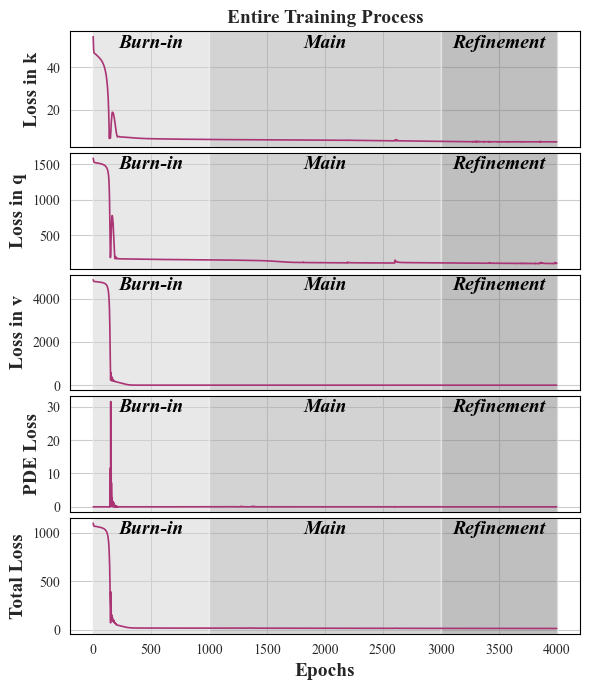

In [36]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(6,7), sharex=True)

axs[0].plot(occu_all, color = '#aa3474',label = "Training", linewidth = 1.2)
# axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Loss in k', fontsize=14, weight = 'bold')
axs[0].set_title('Entire Training Process', fontsize=14, weight='bold')

burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[0].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[0].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[0].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[0].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[0].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[0].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[0].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[0].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[0].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[0].grid(False)
axs[0].spines['top'].set_color('black')
axs[0].spines['bottom'].set_color('black')
axs[0].spines['left'].set_color('black')
axs[0].spines['right'].set_color('black')

axs[1].plot(flow_all, color = '#aa3474',label = "Training", linewidth = 1.2)
#axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Loss in q', fontsize=14, weight = 'bold')
#axs.set_title('Lk', fontsize=14, weight='bold')

burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[1].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[1].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[1].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[1].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[1].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[1].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[1].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[1].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[1].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[1].grid(False)
axs[1].spines['top'].set_color('black')
axs[1].spines['bottom'].set_color('black')
axs[1].spines['left'].set_color('black')
axs[1].spines['right'].set_color('black')

axs[2].plot(speed_all, color = '#aa3474',label = "Training", linewidth = 1.2)
#axs[2].set_xlabel('Epochs', fontsize=14)
axs[2].set_ylabel('Loss in v', fontsize=14, weight = 'bold')
#axs.set_title('Lk', fontsize=14, weight='bold')

burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[2].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[2].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[2].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[2].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[2].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[2].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[2].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[2].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[2].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[2].grid(False)
axs[2].spines['top'].set_color('black')
axs[2].spines['bottom'].set_color('black')
axs[2].spines['left'].set_color('black')
axs[2].spines['right'].set_color('black')

axs[3].plot(k_t_all, color = '#aa3474',label = "Training", linewidth = 1.2)
#axs[3].set_xlabel('Epochs', fontsize=14)
axs[3].set_ylabel('PDE Loss', fontsize=14, weight = 'bold')
#axs.set_title('Lk', fontsize=14, weight='bold')

burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[3].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[3].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[3].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[3].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[3].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[3].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[3].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[3].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[3].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[3].grid(False)
axs[3].spines['top'].set_color('black')
axs[3].spines['bottom'].set_color('black')
axs[3].spines['left'].set_color('black')
axs[3].spines['right'].set_color('black')

axs[4].plot(loss_all, color = '#aa3474',label = "Training", linewidth = 1.2)
axs[4].set_xlabel('Epochs', fontsize=14, weight = 'bold')
axs[4].set_ylabel('Total Loss', fontsize=14, weight = 'bold')
#axs.set_title('Lk', fontsize=14, weight='bold')

burnin_regions = [0, 1000]
# Add different colored background regions
for i in range(0, len(burnin_regions)-1, 2):
    axs[4].axvspan(burnin_regions[i], burnin_regions[i+1], facecolor='lightgrey', alpha=0.5)
    text_x = (burnin_regions[i] + burnin_regions[i + 1]) / 2
    text_y = axs[4].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Burn-in'  # Customize the text as needed
    axs[4].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

main_regions = [1000, 3000]
# Add different colored background regions
for i in range(0, len(main_regions)-1, 2):
    axs[4].axvspan(main_regions[i], main_regions[i+1], facecolor='darkgrey', alpha=0.5)
    text_x = (main_regions[i] + main_regions[i + 1]) / 2
    text_y = axs[4].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Main'  # Customize the text as needed
    axs[4].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')

refine_regions = [3000, 4000]
# Add different colored background regions
for i in range(0, len(refine_regions)-1, 2):
    axs[4].axvspan(refine_regions[i], refine_regions[i+1], facecolor='grey', alpha=0.5)
    text_x = (refine_regions[i] + refine_regions[i + 1]) / 2
    text_y = axs[4].get_ylim()[1] * 0.9  # Place text at the top of the plot
    text = 'Refinement'  # Customize the text as needed
    axs[4].text(text_x, text_y, text, ha='center', va='center', fontsize=14, color='black', style='italic', weight = 'bold')
# axs[4].grid(False)
axs[4].spines['top'].set_color('black')
axs[4].spines['bottom'].set_color('black')
axs[4].spines['left'].set_color('black')
axs[4].spines['right'].set_color('black')
plt.tight_layout()
#plt.subplots_adjust(hspace=0.1, wspace=0.3)

plt.subplots_adjust(hspace=0.05)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Losses/All_loss_plots.png", dpi = 300)

# Main Refinement Step Detailed Plots


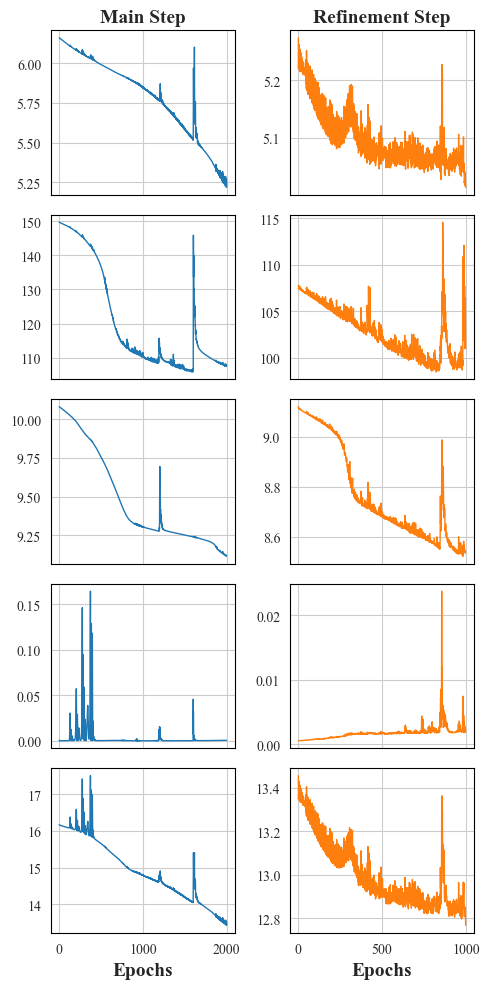

In [37]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(5,10), sharex='col')
axs[0,0].plot(occu_main, color = '#1f77b4', linewidth = 1)
#axs[0].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[0].set_ylabel('Loss', fontsize=14, weight = 'bold')
axs[0,0].set_title('Main Step', fontsize=14, weight='bold')

# axs[0].grid(False)
axs[0,0].spines['top'].set_color('black')
axs[0,0].spines['bottom'].set_color('black')
axs[0,0].spines['left'].set_color('black')
axs[0,0].spines['right'].set_color('black')

axs[0,1].plot(occu_refine, color = '#ff7f0e', linewidth = 1)
#axs[1].set_xlabel('Epochs', fontsize=14, weight = 'bold')
axs[0,1].set_title('Refinement Step', fontsize=14, weight='bold')
# axs[1].grid(False)
axs[0,1].spines['top'].set_color('black')
axs[0,1].spines['bottom'].set_color('black')
axs[0,1].spines['left'].set_color('black')
axs[0,1].spines['right'].set_color('black')


axs[1,0].plot(flow_main, color = '#1f77b4', linewidth = 1)
#axs[0].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[0].set_ylabel('Loss', fontsize=14, weight = 'bold')
#axs[0].set_title('Main Step', fontsize=14, weight='bold')

# axs[0].grid(False)
axs[1,0].spines['top'].set_color('black')
axs[1,0].spines['bottom'].set_color('black')
axs[1,0].spines['left'].set_color('black')
axs[1,0].spines['right'].set_color('black')

axs[1,1].plot(flow_refine, color = '#ff7f0e', linewidth = 1)
#axs[1].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[1].set_title('Refinement Step', fontsize=14, weight='bold')
# axs[1].grid(False)
axs[1,1].spines['top'].set_color('black')
axs[1,1].spines['bottom'].set_color('black')
axs[1,1].spines['left'].set_color('black')
axs[1,1].spines['right'].set_color('black')

axs[2,0].plot(speed_main, color = '#1f77b4', linewidth = 1)
#axs[0].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[0].set_ylabel('Loss', fontsize=14, weight = 'bold')
#axs[0].set_title('Main Step', fontsize=14, weight='bold')

# axs[0].grid(False)
axs[2,0].spines['top'].set_color('black')
axs[2,0].spines['bottom'].set_color('black')
axs[2,0].spines['left'].set_color('black')
axs[2,0].spines['right'].set_color('black')

axs[2,1].plot(speed_refine, color = '#ff7f0e', linewidth = 1)
#axs[1].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[1].set_title('Refinement Step', fontsize=14, weight='bold')
# axs[1].grid(False)
axs[2,1].spines['top'].set_color('black')
axs[2,1].spines['bottom'].set_color('black')
axs[2,1].spines['left'].set_color('black')
axs[2,1].spines['right'].set_color('black')

axs[3,0].plot(k_t_main, color = '#1f77b4', linewidth = 1)
#axs[0].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[0].set_ylabel('Loss', fontsize=14, weight = 'bold')
#axs[0].set_title('Main Step', fontsize=14, weight='bold')

# axs[0].grid(False)
axs[3,0].spines['top'].set_color('black')
axs[3,0].spines['bottom'].set_color('black')
axs[3,0].spines['left'].set_color('black')
axs[3,0].spines['right'].set_color('black')

axs[3,1].plot(k_t_refine, color = '#ff7f0e', linewidth = 1)
#axs[1].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[1].set_title('Refinement Step', fontsize=14, weight='bold')
# axs[1].grid(False)
axs[3,1].spines['top'].set_color('black')
axs[3,1].spines['bottom'].set_color('black')
axs[3,1].spines['left'].set_color('black')
axs[3,1].spines['right'].set_color('black')

axs[4,0].plot(main_losses, color = '#1f77b4', linewidth = 1)
axs[4,0].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[0].set_ylabel('Loss', fontsize=14, weight = 'bold')
#axs[0].set_title('Main Step', fontsize=14, weight='bold')

# axs[0].grid(False)
axs[4,0].spines['top'].set_color('black')
axs[4,0].spines['bottom'].set_color('black')
axs[4,0].spines['left'].set_color('black')
axs[4,0].spines['right'].set_color('black')

axs[4,1].plot(refine_losses, color = '#ff7f0e', linewidth = 1)
axs[4,1].set_xlabel('Epochs', fontsize=14, weight = 'bold')
#axs[1].set_title('Refinement Step', fontsize=14, weight='bold')
# axs[1].grid(False)
axs[4,1].spines['top'].set_color('black')
axs[4,1].spines['bottom'].set_color('black')
axs[4,1].spines['left'].set_color('black')
axs[4,1].spines['right'].set_color('black')

plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Losses/main_refine_plots.png", dpi = 300, transparent=True, bbox_inches='tight')